#**Taxi Trips Chicago - Data Cleaning and Fare Prediction**#




*   Installing Catboost - Model used for Fare prediction in this project.
*   Intalling Haversine - Module that calculates shortest distance between two geographical points.



In [ ]:
!pip install catboost
!pip install haversine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00


Importing all the important libraries that will be used throughout this project.

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

Creating the Dataframe (df) which reads the CSV file from the mounted Google Drive using Pandas.

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Datasets/Chicago.csv")

Finding the total number of NULL values in each column of the dataframe.

In [ ]:
df.isnull().sum()

Trip ID                             0
Taxi ID                             1
Trip Start Timestamp                0
Trip End Timestamp                 18
Trip Seconds                      383
Trip Miles                          7
Pickup Census Tract           1159874
Dropoff Census Tract          1188486
Pickup Community Area           53795
Dropoff Community Area         185553
Fare                             5720
Tips                             5720
Tolls                            5720
Extras                           5720
Trip Total                       5720
Payment Type                        0
Company                             0
Pickup Centroid Latitude        52997
Pickup Centroid Longitude       52997
Pickup Centroid Location        52997
Dropoff Centroid Latitude      175649
Dropoff Centroid Longitude     175649
Dropoff Centroid  Location     175649
dtype: int64

Finding the total number of Duplicate values in the dataframe.

In [ ]:
df.duplicated().sum()

0



Dropping columns 'Pickup Census Tract' and 'Dropoff Census Tract' because the two fields consist of 65% NULL values of the complete dataframe. Also, these fields do not tend serve any purpose in building of the model.




In [ ]:
df.drop('Pickup Census Tract', axis=1, inplace=True)
df.drop('Dropoff Census Tract', axis=1, inplace=True)

Dropping NULL values from columns until all of them are deleted because the dataframe is observed to be sufficiently large and deleting these rows would barely reduce the accuracy of the Fare prediction model.

In [ ]:
df.dropna(subset=['Trip Seconds'], inplace=True)
df.dropna(subset=['Trip Miles'], inplace=True)
df.dropna(subset=['Fare'], inplace=True)
df.dropna(subset=['Taxi ID'], inplace=True)
df.dropna(subset=['Dropoff Centroid  Location'], inplace=True)
df.dropna(subset=['Pickup Community Area'], inplace=True)
df.dropna(subset=['Dropoff Community Area'], inplace=True)

Rechecking for NULL values in dataframe.

In [ ]:
df.isnull().sum()

Trip ID                       0
Taxi ID                       0
Trip Start Timestamp          0
Trip End Timestamp            0
Trip Seconds                  0
Trip Miles                    0
Pickup Community Area         0
Dropoff Community Area        0
Fare                          0
Tips                          0
Tolls                         0
Extras                        0
Trip Total                    0
Payment Type                  0
Company                       0
Pickup Centroid Latitude      0
Pickup Centroid Longitude     0
Pickup Centroid Location      0
Dropoff Centroid Latitude     0
Dropoff Centroid Longitude    0
Dropoff Centroid  Location    0
dtype: int64

Parsing the datatypes of fields which will contribute to categorical features for the Catboost model.

In [ ]:
df['Trip Start Timestamp']=pd.to_datetime(df['Trip Start Timestamp'])
df['Trip End Timestamp']=pd.to_datetime(df['Trip End Timestamp'])
df['Pickup Community Area'] = df['Pickup Community Area'].astype('int32')
df['Dropoff Community Area'] = df['Dropoff Community Area'].astype('int32')
df['Extras'] = df['Extras'].astype('int32')
df['Tolls'] = df['Tolls'].astype('int32')

<ipython-input-8-f94ce9da1bd6>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Trip Start Timestamp']=pd.to_datetime(df['Trip Start Timestamp'])
<ipython-input-8-f94ce9da1bd6>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Trip End Timestamp']=pd.to_datetime(df['Trip End Timestamp'])


Adding field of Trip Minutes to make the calucation easier and dropping the column of Trip Seconds.

In [ ]:
df['Trip Minutes']=df['Trip Seconds']/60
df.drop('Trip Seconds', axis=1, inplace=True)

Adding fields of Trip Start Hour and Trip Start Day which will again contribute to categorical features of model, as it is often observable that the fare while peak hours tend to increase because of high demand.

In [ ]:
df['Trip Start Hour'] = df['Trip Start Timestamp'].dt.hour
df['Trip Start Day'] = df['Trip Start Timestamp'].dt.dayofweek
df['Trip Speed'] = df['Trip Miles'] / df['Trip Minutes']

The abnormal values are deleted in the following cell so as to make the analysis on those entries which can be actually classified as a Cab Trip. For Example: It is logically and practically impossible to have the average speed of trip to be greater than 115 kmph (or 1.2 Miles per minute). So those values are deleted from the dataframe.

In [ ]:
df = df[(df['Trip Minutes'] >= 3) & (df['Trip Minutes'] <= 350)]
df=df[(df['Trip Miles'] >= 0.15) & (df['Trip Miles'] <= 36)]
df=df[(df['Trip Speed'] >= 0.1) & (df['Trip Speed'] <= 1.5)]
df=df[(df['Fare'] >= 1) & (df['Fare'] <= 100)]
df=df[(df['Trip Total'] >= 4) & (df['Trip Total'] <= 120)]
df=df[(df['Tolls'] >= 0) & (df['Tolls'] <= 1)]
df=df[(df['Extras'] >= 0) & (df['Extras'] <= 7)]
df=df[(df['Tips'] >= 0) & (df['Tips'] <= 20)]

Analysing and plotting the Companies and their trips covered through a Pie Chart.

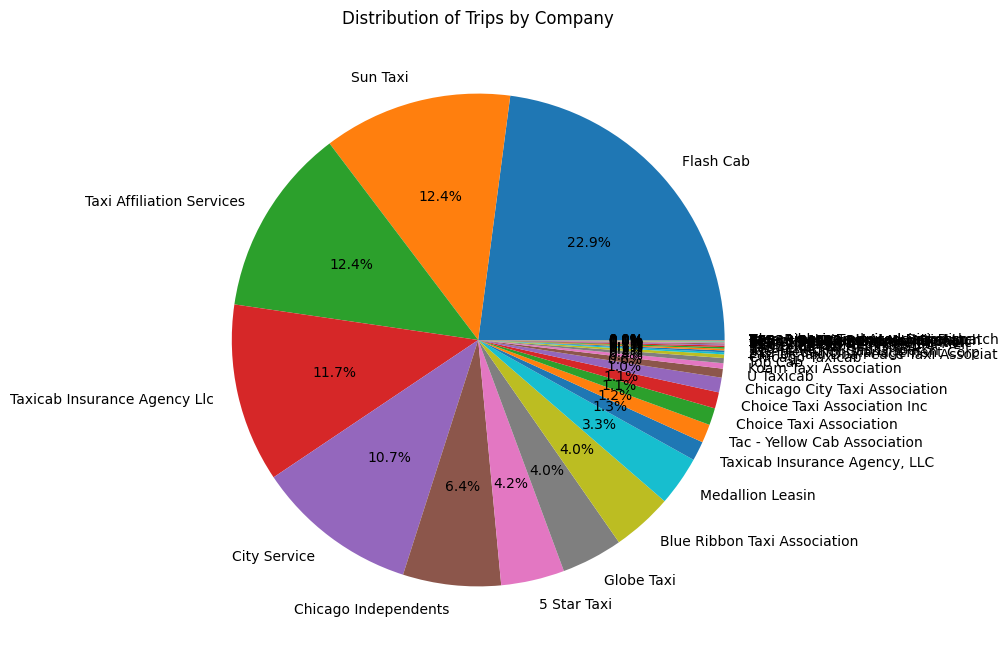

In [ ]:
company_trip_counts = df['Company'].value_counts()

plt.figure(figsize=(12, 8))
plt.pie(company_trip_counts, labels=company_trip_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Trips by Company')
plt.show()

Filtering the dataframe and keeping only the entries corresponding to the top 10 companies. It will help to add the field 'Company' to categorical features and make the model more time efficient.

In [ ]:
top_10_companies = df['Company'].value_counts().nlargest(10).index
df = df[df['Company'].isin(top_10_companies)]

Making changes in column 'Payment Type' so that it can be added as a categorical feature while training Catboost model.

In [ ]:
# Before
print("Before changes:")
print(df['Payment Type'].value_counts())


# Updating the column
df = df[df['Payment Type'] != 'No Charge']
df = df[df['Payment Type'] != 'Dispute']
df.loc[df['Payment Type'] == 'Unknown', 'Payment Type'] = 'Coupon'


# After
print("\nAfter changes:")
print(df['Payment Type'].value_counts())

Before changes:
Payment Type
Credit Card    481510
Cash           301415
Mobile         221780
Prcard         215835
Unknown         47648
No Charge         878
Dispute           123
Name: count, dtype: int64

After changes:
Payment Type
Credit Card    481510
Cash           301415
Mobile         221780
Prcard         215835
Coupon          47648
Name: count, dtype: int64


Creating Company and Payment Type mapping to simplify the input provided to the model.

In [ ]:
company_mapping = {
    'Flash Cab': 1,
    'Taxicab Insurance Agency Llc': 2,
    'City Service': 3,
    'Chicago Independents': 4,
    'Taxi Affiliation Services': 5,
    'Sun Taxi': 6,
    '5 Star Taxi': 7,
    'Globe Taxi': 8,
    'Blue Ribbon Taxi Association': 9,
    'Medallion Leasin': 10
}

payment_type_mapping = {
    'Credit Card': 1,
    'Mobile': 2,
    'Cash': 3,
    'Prcard': 4,
    'Coupon': 5
}

# Replace values using the mappings
df['Company'] = df['Company'].map(company_mapping)
df['Payment Type'] = df['Payment Type'].map(payment_type_mapping)
df['Company'] = df['Company'].astype('int32')
df['Payment Type'] = df['Payment Type'].astype('int32')

Creating the column 'Displacement' which calculates the shortest distance between Pickup and Dropoff location. The column 'Difference' stores the difference between 'Trip Miles' and 'Displacement' which should always be greater than or equal to 0.

In [ ]:
def calculate_displacement(row):
    pickup_coords = (row['Pickup Centroid Latitude'], row['Pickup Centroid Longitude'])
    dropoff_coords = (row['Dropoff Centroid Latitude'], row['Dropoff Centroid Longitude'])
    return haversine(pickup_coords, dropoff_coords, unit=Unit.MILES)

df['Displacement'] = df.apply(calculate_displacement, axis=1)
df['Difference'] = df['Trip Miles'] - df['Displacement']

Printing the Maximum and Minimum Difference in miles before manipulation.

In [ ]:
max_difference = df['Difference'].max()
min_difference = df['Difference'].min()

print(f'Maximum difference before manipulation: {max_difference}')
print(f'Minimum difference before manipulation: {min_difference}')

Maximum difference before manipulation: 36.0
Minimum difference before manipulation: -20.55396641572298


Manipulating the 'Difference' column and then printing the Maximumn, Minimum, Mean, Median and Mode of the column.

In [ ]:
df = df[(df['Difference'] >= 0) & (df['Difference'] <= 9)]

max_difference = df['Difference'].max()
min_difference = df['Difference'].min()
print(f'Maximum difference after manipulation: {max_difference}')
print(f'Minimum difference after manipulation: {min_difference}')

mean_diff = df['Difference'].mean()
median_diff = df['Difference'].median()
mode_diff = df['Difference'].mode()[0]

Maximum difference after manipulation: 9.0
Minimum difference after manipulation: 2.148889922581887e-05


Plotting the density curve of 'Difference' and marking the values of mean, median and mode.

<ipython-input-19-6939fa5e7768>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Difference'], shade=True, label='Density')


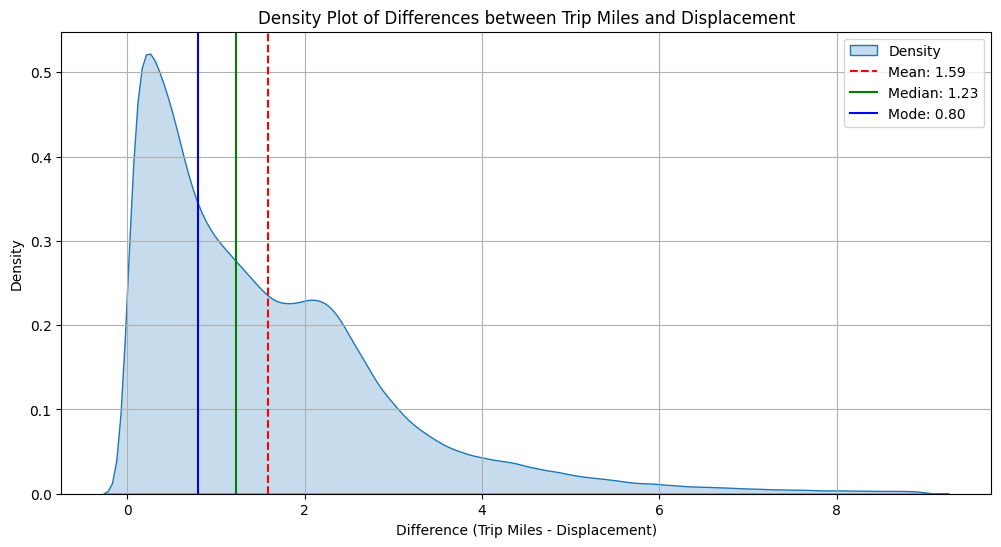

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Difference'], shade=True, label='Density')
plt.axvline(mean_diff, color='r', linestyle='--', label=f'Mean: {mean_diff:.2f}')
plt.axvline(median_diff, color='g', linestyle='-', label=f'Median: {median_diff:.2f}')
plt.axvline(mode_diff, color='b', linestyle='-', label=f'Mode: {mode_diff:.2f}')
plt.xlabel('Difference (Trip Miles - Displacement)')
plt.ylabel('Density')
plt.title('Density Plot of Differences between Trip Miles and Displacement')
plt.legend()
plt.grid(True)
plt.show()

Dropping the columns 'Difference' and 'Displacement'.

In [ ]:
df.drop('Difference', axis=1, inplace=True)
df.drop('Displacement', axis=1, inplace=True)

Analysing the Mean, Median and Mode of Trip Speed.

In [ ]:
print(df['Trip Speed'].mean())
print(df['Trip Speed'].median())
print(df['Trip Speed'].mode()[0])

0.3442438744183842
0.30490018148820325
0.15


Fixing the Indexing of the updated dataframe.

In [ ]:
df = df.reset_index(drop=True)

Analysing the final dataframe before feeding it to the model.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065573 entries, 0 to 1065572
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     1065573 non-null  object        
 1   Taxi ID                     1065573 non-null  object        
 2   Trip Start Timestamp        1065573 non-null  datetime64[ns]
 3   Trip End Timestamp          1065573 non-null  datetime64[ns]
 4   Trip Miles                  1065573 non-null  float64       
 5   Pickup Community Area       1065573 non-null  int32         
 6   Dropoff Community Area      1065573 non-null  int32         
 7   Fare                        1065573 non-null  float64       
 8   Tips                        1065573 non-null  float64       
 9   Tolls                       1065573 non-null  int32         
 10  Extras                      1065573 non-null  int32         
 11  Trip Total              

Plotting Scatter graphs of 'Fare' VS 'Tips', 'Tolls', 'Extras' and 'Trip Total' to analyse the spread and distribition of these columns.

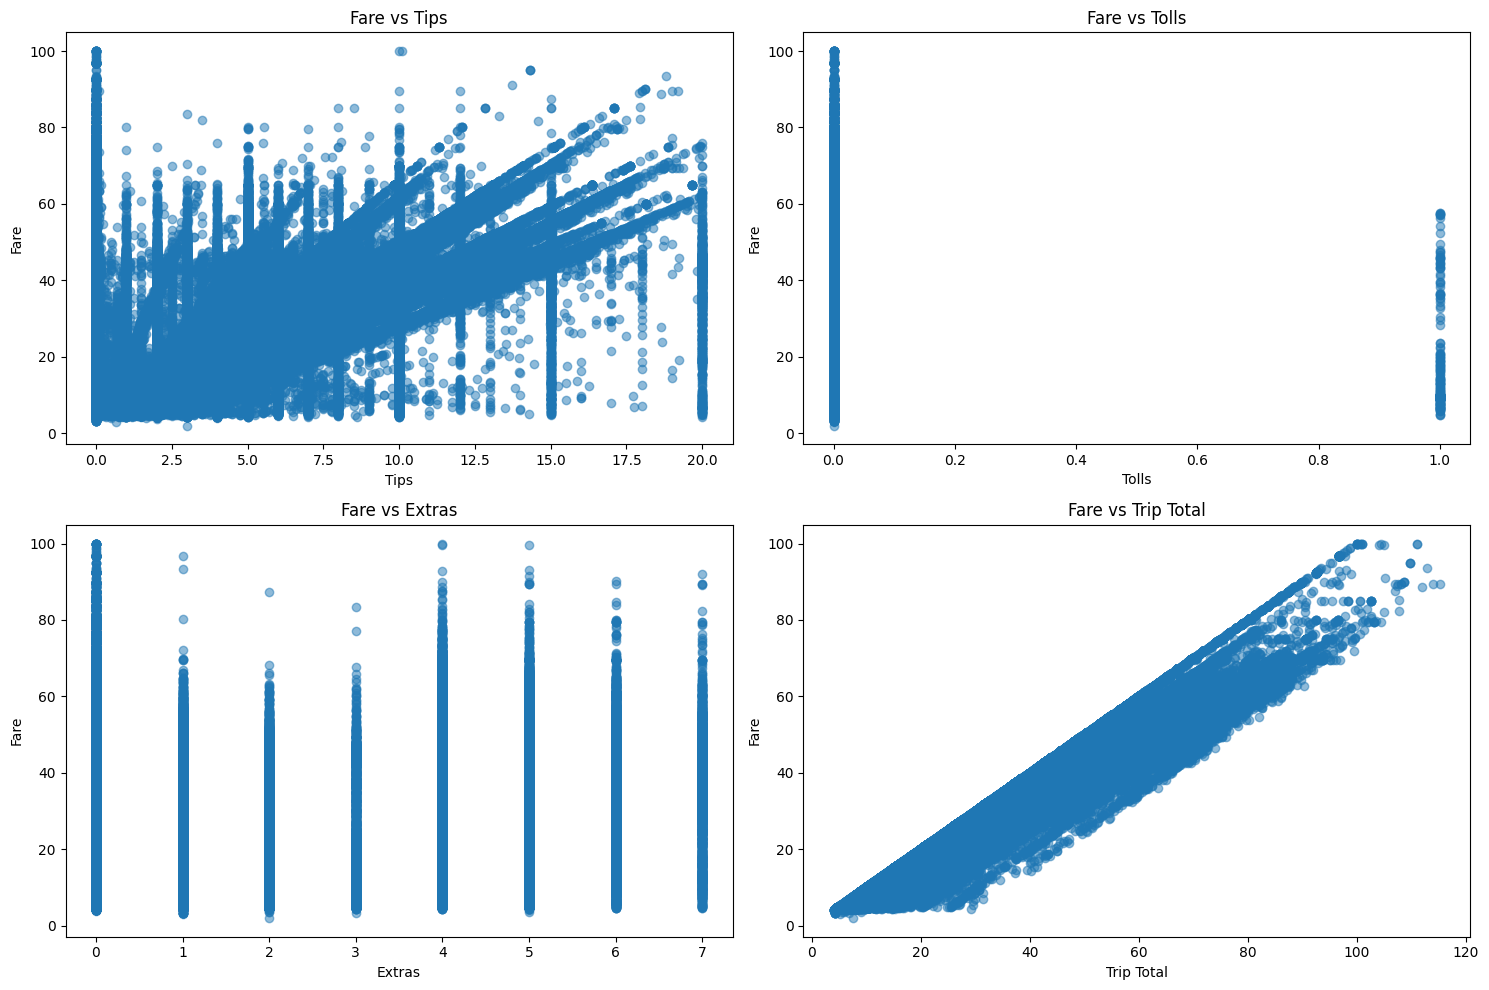

In [ ]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot for Fare vs Tips
axes[0, 0].scatter(df['Tips'], df['Fare'], alpha=0.5)
axes[0, 0].set_title('Fare vs Tips')
axes[0, 0].set_xlabel('Tips')
axes[0, 0].set_ylabel('Fare')

# Scatter plot for Fare vs Tolls
axes[0, 1].scatter(df['Tolls'], df['Fare'], alpha=0.5)
axes[0, 1].set_title('Fare vs Tolls')
axes[0, 1].set_xlabel('Tolls')
axes[0, 1].set_ylabel('Fare')

# Scatter plot for Fare vs Extras
axes[1, 0].scatter(df['Extras'], df['Fare'], alpha=0.5)
axes[1, 0].set_title('Fare vs Extras')
axes[1, 0].set_xlabel('Extras')
axes[1, 0].set_ylabel('Fare')

# Scatter plot for Fare vs Trip Total
axes[1, 1].scatter(df['Trip Total'], df['Fare'], alpha=0.5)
axes[1, 1].set_title('Fare vs Trip Total')
axes[1, 1].set_xlabel('Trip Total')
axes[1, 1].set_ylabel('Fare')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()




1.   Specifying the features and target variable and running the Catboost Regressor model first on training dataset (80%) and then on testing data (20%).
2.   Evaluation of model using R² score and Mean Square Error.
3.   Plotting the graph of Predicted fare VS Actual fare.



Mean Squared Error: 4.70374194411054
R² Score: 0.9863428425995127


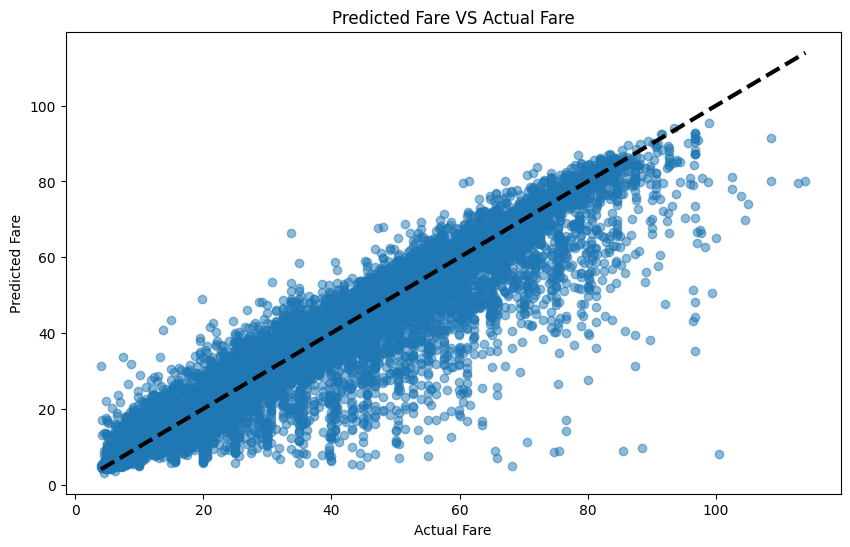

In [ ]:
# Setting the target and feature parameters
features = ['Trip Miles', 'Pickup Community Area', 'Dropoff Community Area', 'Trip Minutes', 'Trip Start Hour', 'Trip Start Day' , 'Company', 'Tips', 'Tolls', 'Extras', 'Payment Type']
target = 'Trip Total'

# Storing the values features and target in X and y respectively
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specifying the categorical features
cat_features = ['Pickup Community Area', 'Trip Start Hour', 'Trip Start Day', 'Dropoff Community Area', 'Company', 'Tolls', 'Extras', 'Payment Type']

# Building, training and testing the model
model = CatBoostRegressor(cat_features=cat_features, verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Adding the predicted fare to the local scope DataFrame
X_test['Predicted Fare'] = y_pred
X_test['Actual Fare'] = y_test.values

# Plot the actual fare vs. predicted fare
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Actual Fare'], X_test['Predicted Fare'], alpha=0.5)
plt.plot([X_test['Actual Fare'].min(), X_test['Actual Fare'].max()], [X_test['Actual Fare'].min(), X_test['Actual Fare'].max()], 'k--', lw=3)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Predicted Fare VS Actual Fare')
plt.show()

Downloading the final dataframe (df) from Google Colab to local machine.

In [ ]:
df.to_csv('Taxi Trips Chicago.csv', index=False)
from google.colab import files
files.download('Taxi Trips Chicago.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pickling the model.

In [ ]:
pickle.dump(model, open('fare.pkl', 'wb'))